In [3]:
# Instructions
# 1. An Image Folder“ HAR_Images” is provided. It has three classes.
# 2. Using Pytorch, design Artificial Neural Network (ANN) to classify the categories of HAR_Images dataset.
# 3. Calculate the training and testing accuracies.
# 4. Plot training loss vs epochs.
# 5. Plot training and testing accuracies against epochs.
# 6. Your accuracy should be close to 95%.


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from torch.utils.data import DataLoader, dataset , random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# first we need to load the data and standardize some transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
data = datasets.ImageFolder(root="HAR_Images", transform=transform)

# now lets split the data into training and testing
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

# now we need to create the dataloaders for the training and testing data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# lets try to use the code the stupid professor gave us

# ANNiris = nn.Sequential(
#           nn.Linear(4,32),
#           nn.ReLU(),
#           nn.Linear(32,32),
#           nn.ReLU(),
#           nn.Linear(32,3),
#           )

ANNiris = nn.Sequential(
                nn.Flatten(),  # Flatten the image (3 x 64 x 64) into a vector.
                nn.Linear(3 * 64 * 64, 512),  # First hidden layer.
                nn.ReLU(),  # Activation.
                nn.Linear(512, 128),  # Second hidden layer.
                nn.ReLU(),  # Activation.
                nn.Linear(128, len(data.classes))  # Output layer.
).to(device)
# learningRate = 0.01

lossfunc = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(ANNiris.parameters(), lr=learningRate)
# changing the optimizer to Adam because SGD did not work
optimizer = optim.Adam(ANNiris.parameters(), lr=0.001)

epochs = 10
losses = torch.zeros(epochs)  # setting place holder for for loop

# lists to record results
train_losses = []
train_accuracies = []
test_accuracies = []
#  no need to manuallu convert the data as flatten does it for us
# for i, j in train_loader:
#     temp_data = i.view(-1, 4)
#     labels = j

for epoch in range(epochs):
    ANNiris.train() # Setting the model to training mode
    # these help track the losses and accuracy for each epoch
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0
    # adding a loop to get the data from the train_loader and using NN.Squential to get required input
    for images, labels in train_loader:
        # first we need to move the data to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        ypred = ANNiris(images)
        loss = lossfunc(ypred, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        # get the predicted class by getting the index of the max value in the output
        _, predicted = torch.max(ypred, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # lets calculate the loss and accuracy for the epoch
    train_loss = epoch_loss / total_train
    train_accuracy = correct_train / total_train
    # finally we append the results to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")

#  now lets work on test model and compare acccuracies
for epoch in range(epochs):
    ANNiris.eval() # Setting the model to evaluation mode
    correct_test = 0
    total_test = 0
    # adding a loop to get the data from the test_loader and using NN.Squential to get required input
    for images, labels in test_loader:
        # first we need to move the data to the device
        images, labels = images.to(device), labels.to(device)
        ypred = ANNiris(images)
        # get the predicted class by getting the index of the max value in the output
        _, predicted = torch.max(ypred, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    # lets calculate the accuracy for the epoch
    test_accuracy = correct_test / total_test
    # finally we append the results to the lists
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Test Accuracy: {test_accuracy:.2f}")



Epoch 1/10, Train Loss: 0.69, Train Accuracy: 0.67
Epoch 2/10, Train Loss: 0.36, Train Accuracy: 0.85
Epoch 3/10, Train Loss: 0.24, Train Accuracy: 0.91
Epoch 4/10, Train Loss: 0.21, Train Accuracy: 0.92
Epoch 5/10, Train Loss: 0.16, Train Accuracy: 0.94
Epoch 6/10, Train Loss: 0.12, Train Accuracy: 0.95
Epoch 7/10, Train Loss: 0.18, Train Accuracy: 0.93
Epoch 8/10, Train Loss: 0.13, Train Accuracy: 0.95
Epoch 9/10, Train Loss: 0.12, Train Accuracy: 0.96
Epoch 10/10, Train Loss: 0.09, Train Accuracy: 0.97
Epoch 1/10, Test Accuracy: 0.96
Epoch 2/10, Test Accuracy: 0.96
Epoch 3/10, Test Accuracy: 0.96
Epoch 4/10, Test Accuracy: 0.96
Epoch 5/10, Test Accuracy: 0.96
Epoch 6/10, Test Accuracy: 0.96
Epoch 7/10, Test Accuracy: 0.96
Epoch 8/10, Test Accuracy: 0.96
Epoch 9/10, Test Accuracy: 0.96
Epoch 10/10, Test Accuracy: 0.96


   Epochs  Train Loss  Train Accuracy  Test Accuracy
0       1    0.685000        0.670539       0.964427
1       2    0.364515        0.846515       0.964427
2       3    0.239097        0.906080       0.964427
3       4    0.210866        0.919921       0.964427
4       5    0.162768        0.935492       0.964427
5       6    0.116094        0.954276       0.964427
6       7    0.184136        0.930796       0.964427
7       8    0.127247        0.951063       0.964427
8       9    0.116707        0.955512       0.964427
9      10    0.091678        0.967128       0.964427


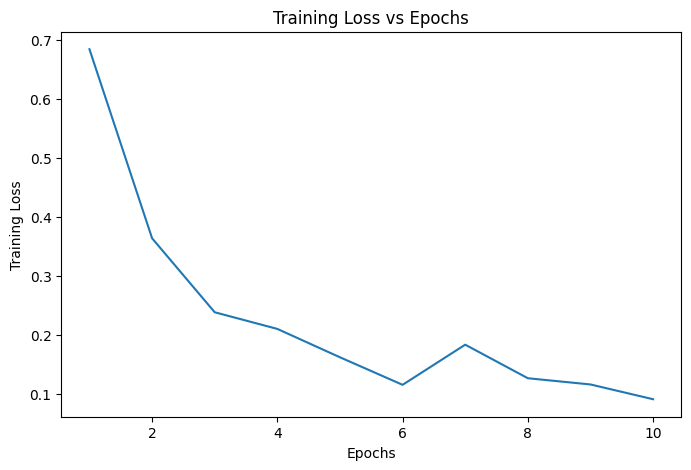

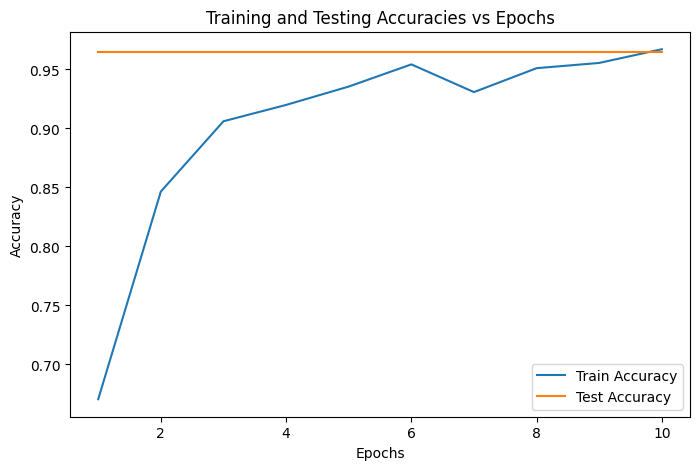

In [4]:
# lets save the results in a df
results = pd.DataFrame({
    "Epochs": list(range(1, epochs+1)),
    "Train Loss": train_losses,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies
})
print(results)

# lets plot the results finally!!!!!!!
# 4. Plot training loss vs epochs.
# 5. Plot training and testing accuracies against epochs.
# 6. Your accuracy should be close to 95%.  its 95 ish so good enough, who knows if it will change when i rerun it, so i will finish it in one go

# Plot for training loss against epochs using the df
plt.figure(figsize=(8,5))
plt.plot(results["Epochs"], results["Train Loss"], label="Train Loss")
plt.title("Training Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

# Plot for training and testing accuracies against epochs using the df
plt.figure(figsize=(8,5))
plt.plot(results["Epochs"], results["Train Accuracy"], label="Train Accuracy")
plt.plot(results["Epochs"], results["Test Accuracy"], label="Test Accuracy")
plt.title("Training and Testing Accuracies vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()